# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


### Experiment setup
* Here we simply load the game and check that it works

In [64]:
import gym
make_env = lambda: gym.make("LunarLander-v2")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2017-11-05 01:32:56,748] Making new env: LunarLander-v2


# Neural Network body

In [65]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)


nn = DenseLayer(observation_layer, 200, nonlinearity=elu)
nn = DenseLayer(nn, 200, nonlinearity=elu)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(nn,num_units=n_actions,
                           nonlinearity=None,name="q-values")

Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [66]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [67]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)

In [68]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [69]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

[2017-11-05 01:32:58,913] Making new env: LunarLander-v2


In [70]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

actions: [[3 3 3 3 3]]
rewards: [[-1.11105027 -1.05721358 -1.73667379 -1.969974    0.        ]]
CPU times: user 4.25 ms, sys: 2.7 ms, total: 6.96 ms
Wall time: 5.45 ms


In [71]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [72]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [73]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [74]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [75]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-11-05 01:33:05,235] Making new env: LunarLander-v2
[2017-11-05 01:33:05,248] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-11-05 01:33:05,255] Starting new video recorder writing to /Users/AntonKarazeev/WD/mipt_hw/records/openaigym.video.5.59897.video000000.mp4
[2017-11-05 01:33:07,614] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/AntonKarazeev/WD/mipt_hw/records')


Episode finished after 58 timesteps with reward=-555.8726577113229


In [22]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [76]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = -90

In [77]:
from tqdm import trange

for i in trange(1000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

 10%|▉         | 99/1000 [00:05<00:45, 19.87it/s][2017-11-05 01:33:29,257] Making new env: LunarLander-v2
[2017-11-05 01:33:29,268] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-11-05 01:33:29,528] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/AntonKarazeev/WD/mipt_hw/records')


Episode finished after 95 timesteps with reward=-159.82082361174167
Episode finished after 115 timesteps with reward=-135.11981594927454
Episode finished after 129 timesteps with reward=-246.05375694184414
iter=100	epsilon=0.910
Current score(mean over 3) = -180.331


 20%|█▉        | 199/1000 [00:10<00:41, 19.12it/s][2017-11-05 01:33:34,986] Making new env: LunarLander-v2
[2017-11-05 01:33:34,994] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-05 01:33:35,188] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/AntonKarazeev/WD/mipt_hw/records')
 20%|██        | 201/1000 [00:11<01:07, 11.92it/s]

Episode finished after 73 timesteps with reward=-120.44162507428929
Episode finished after 126 timesteps with reward=-172.32343639317583
Episode finished after 113 timesteps with reward=-630.2822908291743
iter=200	epsilon=0.828
Current score(mean over 3) = -307.682


 30%|██▉       | 298/1000 [00:16<00:39, 17.62it/s][2017-11-05 01:33:40,798] Making new env: LunarLander-v2
[2017-11-05 01:33:40,807] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-05 01:33:41,108] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/AntonKarazeev/WD/mipt_hw/records')
 30%|███       | 300/1000 [00:16<01:11,  9.75it/s]

Episode finished after 162 timesteps with reward=-348.0326640110933
Episode finished after 189 timesteps with reward=-576.0171051623773
Episode finished after 138 timesteps with reward=-242.0425588613409
iter=300	epsilon=0.754
Current score(mean over 3) = -388.697


 40%|███▉      | 398/1000 [00:23<00:33, 17.80it/s][2017-11-05 01:33:47,616] Making new env: LunarLander-v2
[2017-11-05 01:33:47,624] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 73 timesteps with reward=-169.3562672570085
Episode finished after 245 timesteps with reward=-250.89500582145067


[2017-11-05 01:33:47,904] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/AntonKarazeev/WD/mipt_hw/records')
 40%|████      | 402/1000 [00:23<00:54, 10.93it/s]

Episode finished after 83 timesteps with reward=-214.02276580233104
iter=400	epsilon=0.687
Current score(mean over 3) = -211.425


 50%|████▉     | 498/1000 [00:29<00:28, 17.63it/s][2017-11-05 01:33:54,191] Making new env: LunarLander-v2
[2017-11-05 01:33:54,201] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 186 timesteps with reward=-226.47349365145485
Episode finished after 113 timesteps with reward=-75.23985197717037


[2017-11-05 01:33:54,619] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/AntonKarazeev/WD/mipt_hw/records')
 50%|█████     | 502/1000 [00:30<00:53,  9.32it/s]

Episode finished after 220 timesteps with reward=-639.0739211760753
iter=500	epsilon=0.626
Current score(mean over 3) = -313.596


 60%|█████▉    | 598/1000 [00:38<00:33, 11.85it/s][2017-11-05 01:34:02,753] Making new env: LunarLander-v2
[2017-11-05 01:34:02,762] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-05 01:34:03,009] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/AntonKarazeev/WD/mipt_hw/records')
 60%|██████    | 600/1000 [00:38<00:47,  8.35it/s]

Episode finished after 135 timesteps with reward=-319.2866226714124
Episode finished after 90 timesteps with reward=-217.07755441998074
Episode finished after 143 timesteps with reward=-86.32558865686943
iter=600	epsilon=0.571
Current score(mean over 3) = -207.563


 70%|██████▉   | 698/1000 [00:45<00:19, 15.81it/s][2017-11-05 01:34:09,654] Making new env: LunarLander-v2
[2017-11-05 01:34:09,664] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-05 01:34:09,914] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/AntonKarazeev/WD/mipt_hw/records')
 70%|███████   | 700/1000 [00:45<00:30,  9.69it/s]

Episode finished after 140 timesteps with reward=-362.8532967799927
Episode finished after 107 timesteps with reward=-535.471029392415
Episode finished after 91 timesteps with reward=-278.6625033311692
iter=700	epsilon=0.522
Current score(mean over 3) = -392.329


 80%|███████▉  | 798/1000 [00:53<00:13, 14.87it/s][2017-11-05 01:34:18,157] Making new env: LunarLander-v2
[2017-11-05 01:34:18,166] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-05 01:34:18,471] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/AntonKarazeev/WD/mipt_hw/records')
 80%|████████  | 800/1000 [00:54<00:22,  8.92it/s]

Episode finished after 181 timesteps with reward=-318.3122095449252
Episode finished after 114 timesteps with reward=-392.7562891905704
Episode finished after 188 timesteps with reward=-461.31541281408363
iter=800	epsilon=0.477
Current score(mean over 3) = -390.795


 90%|████████▉ | 898/1000 [01:01<00:07, 14.22it/s][2017-11-05 01:34:25,562] Making new env: LunarLander-v2
[2017-11-05 01:34:25,570] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 148 timesteps with reward=-654.4404645203474
Episode finished after 218 timesteps with reward=-570.1305510938339


[2017-11-05 01:34:25,972] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/AntonKarazeev/WD/mipt_hw/records')
 90%|█████████ | 902/1000 [01:01<00:10,  9.00it/s]

Episode finished after 214 timesteps with reward=-786.6663217608186
iter=900	epsilon=0.436
Current score(mean over 3) = -670.412


100%|█████████▉| 998/1000 [01:08<00:00, 15.50it/s][2017-11-05 01:34:32,522] Making new env: LunarLander-v2
[2017-11-05 01:34:32,531] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 138 timesteps with reward=-717.3487455395887
Episode finished after 165 timesteps with reward=-464.9145792096632
Episode finished after 149 timesteps with reward=-434.1266411733663


[2017-11-05 01:34:32,817] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/AntonKarazeev/WD/mipt_hw/records')
100%|██████████| 1000/1000 [01:08<00:00,  9.27it/s]

iter=1000	epsilon=0.399
Current score(mean over 3) = -538.797


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


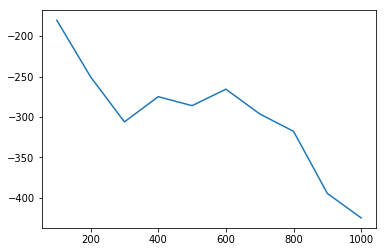

In [78]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda k:k[0]))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [79]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

[2017-11-05 01:35:43,815] Making new env: LunarLander-v2
[2017-11-05 01:35:43,827] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-05 01:35:43,833] Starting new video recorder writing to /Users/AntonKarazeev/WD/mipt_hw/records/openaigym.video.16.59897.video000000.mp4
[2017-11-05 01:35:45,724] Starting new video recorder writing to /Users/AntonKarazeev/WD/mipt_hw/records/openaigym.video.16.59897.video000001.mp4


Episode finished after 103 timesteps with reward=-234.36389963783375
Episode finished after 191 timesteps with reward=-322.53746637275145
Episode finished after 145 timesteps with reward=-532.5478237354165
Episode finished after 164 timesteps with reward=-566.7982091312908
Episode finished after 165 timesteps with reward=-283.1939207705934
Episode finished after 102 timesteps with reward=-202.67568070597474


[2017-11-05 01:35:49,199] Starting new video recorder writing to /Users/AntonKarazeev/WD/mipt_hw/records/openaigym.video.16.59897.video000008.mp4


Episode finished after 170 timesteps with reward=-525.7999878323158
Episode finished after 203 timesteps with reward=-803.2953567524714


[2017-11-05 01:35:53,128] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/AntonKarazeev/WD/mipt_hw/records')


Episode finished after 265 timesteps with reward=-417.67917171791083
Episode finished after 150 timesteps with reward=-261.28202686357804
average reward: [-234.36389963783375, -322.53746637275145, -532.5478237354165, -566.79820913129083, -283.19392077059342, -202.67568070597474, -525.79998783231576, -803.29535675247143, -417.67917171791083, -261.28202686357804]
